# Predicting bike rentals

Many American cities have communal bike sharing stations where bicycles can be rented by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day. Hadi 

Fanaee-T at the University of Porto compiled this data into a CSV file, which we'll be working with in this project. The file contains 17380 rows, each representing the number of bike rentals for a single hour of a single day. The data and information on each column can be accessed from a dedicated [webpage](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) hosted by the University of California, Irvine's.

In this project, we'll try to predict the total number of bikes people rented in a given hour.

## Initial exploration of the data

In [1]:
import pandas as pd

bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The target value corresponds to the `cnt` column. We'll ignore the `casual` and `registered` columns, since  the `cnt` column is derived from them.

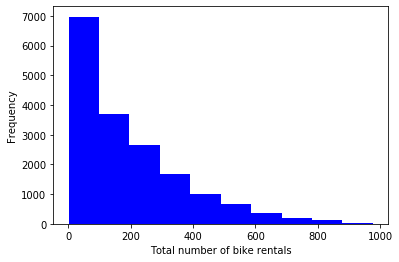

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(bike_rentals['cnt'], facecolor='blue')
plt.xlabel('Total number of bike rentals')
plt.ylabel('Frequency')
plt.show()

In [3]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

The `hr` column contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We will introduce some order into the process by creating a new column with these labels: `morning`, `afternoon`, `evening`, and `night`. This will bundle similar times together, enabling the model to make better decisions.

In [4]:
bike_rentals.hr.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [5]:
def assign_label(hr):
    if hr >= 18:
        label = 3
    elif hr >= 12:
        label = 2
    elif hr >= 6:
        label = 1
    else:
        label = 4
    return label
labels = []
for hr in bike_rentals.hr.unique():
    labels.append( assign_label(hr)  )
print(labels)

[4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3]


In [6]:
bike_rentals['time_label']=bike_rentals['hr'].apply(assign_label)
bike_rentals[['hr', 'time_label']].sample(n=5)

,hr,time_label
16257,3,4
9049,23,3
4157,3,4
1307,16,2
11009,21,3


## Linear regression model

In [7]:
from sklearn.linear_model import LinearRegression

train = bike_rentals.sample(frac=0.8)
test = bike_rentals.drop(train.index)

We'll train a linear regression model using only numeric columns. Of these, we will exclude also `casual` and `registered`.

In [8]:
features = train.select_dtypes(['number']).columns
features = features.drop(['casual','registered','cnt'])
features.tolist()

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [9]:
lr = LinearRegression()
lr.fit(train[features],train['cnt'])
predictions = lr.predict(test[features])

The mean squared error metric (MSE) makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [10]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(test['cnt'],predictions)
MSE

17903.29785353934

The error is very high. This might be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts (check the histogram above).

## Decision tree regressors

In [11]:
from sklearn.tree import DecisionTreeRegressor

In [12]:
# Default parameters
dt = DecisionTreeRegressor()
dt.fit(train[features],train['cnt'])
predictions = dt.predict(test[features])
MSE = mean_squared_error(test['cnt'],predictions)
MSE

3696.4620253164558

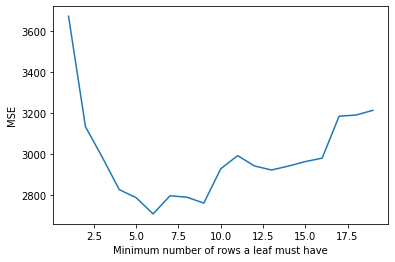

In [13]:
# Tweaking `min_samples_leaf` (minimum number of rows a leaf must have)
min_samples_leaf = range(1,20)
MSEs = []
for i in min_samples_leaf:
    dt = DecisionTreeRegressor(min_samples_leaf=i)
    dt.fit(train[features],train['cnt'])
    predictions = dt.predict(test[features])
    MSE = mean_squared_error(test['cnt'],predictions)
    MSEs.append(MSE)

%matplotlib inline
plt.plot(min_samples_leaf,MSEs)
plt.xlabel('Minimum number of rows a leaf must have')
plt.ylabel('MSE')
plt.show()

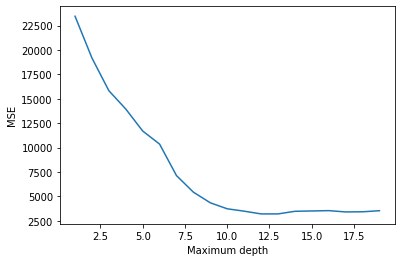

In [14]:
# Tweaking `max_depth` (maximum depth)
max_depth = range(1,20)
MSEs = []
for i in max_depth:
    dt = DecisionTreeRegressor(max_depth=i)
    dt.fit(train[features],train['cnt'])
    predictions = dt.predict(test[features])
    MSE = mean_squared_error(test['cnt'],predictions)
    MSEs.append(MSE)

%matplotlib inline
plt.plot(max_depth,MSEs)
plt.xlabel('Maximum depth')
plt.ylabel('MSE')
plt.show()

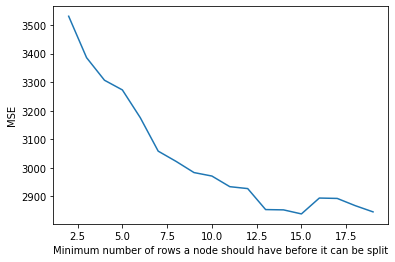

In [15]:
# Tweaking `min_samples_split` (minimum number of rows a node should have before it can be split)
min_samples_split = range(2,20)
MSEs = []
for i in min_samples_split:
    dt = DecisionTreeRegressor(min_samples_split=i)
    dt.fit(train[features],train['cnt'])
    predictions = dt.predict(test[features])
    MSE = mean_squared_error(test['cnt'],predictions)
    MSEs.append(MSE)

%matplotlib inline
plt.plot(min_samples_split,MSEs)
plt.xlabel('Minimum number of rows a node should have before it can be split')
plt.ylabel('MSE')
plt.show()

Decision tree regressors appear to have much higher accuracy than the linear regression model.

## Random forest regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(min_samples_leaf=5)
rf.fit(train[features],train['cnt'])
predictions = rf.predict(test[features])
MSE = mean_squared_error(test['cnt'],predictions)
MSE

2016.5454413022624

By removing some of the sources of overfitting, the random forest accuracy is improved.

In [17]:
from graphviz import Source
from sklearn import tree
from IPython.display import SVG
graph = Source( tree.export_graphviz(rf.estimators_[5], out_file=None, feature_names=train[features].columns))
SVG(graph.pipe(format='svg'))